In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('Clean.csv')

In [443]:
# df_shuffled=df.sample(frac=1)
# train=df_shuffled.iloc[0:70000,:]
# validation=df_shuffled.iloc[70000:85000,:]
# test=df_shuffled.iloc[85000:100000,:]

In [3]:
df = df.drop('Unnamed: 0', axis=1)
#df.head()

In [4]:
X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']

In [446]:
# def normalize(X):
#     for feature in X.columns:
#         X[feature] -= X[feature].mean()
#         X[feature] /= X[feature].std()
#     return X

In [5]:
model = LogisticRegression(class_weight='balanced')
#model = RandomForestClassifier(n_estimators=100)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


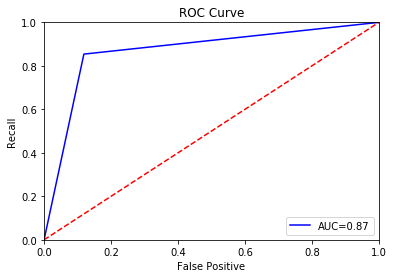

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93     19000
         1.0       0.27      0.85      0.42      1000

    accuracy                           0.88     20000
   macro avg       0.63      0.87      0.67     20000
weighted avg       0.96      0.88      0.91     20000

[[16741  2259]
 [  146   854]]


In [6]:
#X = StandardScaler().fit_transform(X)

X = X.drop(['is_ip_blacklisted','is_email_blacklisted'], axis=1)

#X = X['age_of_account'].to_frame()

for train_indices, test_indices in splitter.split(X, y):
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    
    clf = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    
    fpr, recall, th = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, recall)
    plt.title('ROC Curve')
    plt.plot(fpr,recall, 'b', label='AUC=%0.2f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.ylabel('Recall')
    plt.xlabel('False Positive')
    plt.show()
    
    
#     xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
#     grid = np.c_[xx.ravel(), yy.ravel()]
#     probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
    
#     f, ax = plt.subplots(figsize=(8, 6))
#     ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

#     ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50, cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1)

#     ax.set(aspect="equal", xlim=(-5, 5), ylim=(-5, 5), xlabel="$X_1$", ylabel="$X_2$")
    
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

In [7]:
y_pred_prob

array([[0.96553707, 0.03446293],
       [0.57445477, 0.42554523],
       [0.75721474, 0.24278526],
       ...,
       [0.61845363, 0.38154637],
       [0.95007636, 0.04992364],
       [0.97729319, 0.02270681]])

In [8]:
y_fraud_prob = y_pred_prob[:,1]
y_fraud_prob

array([0.03446293, 0.42554523, 0.24278526, ..., 0.38154637, 0.04992364,
       0.02270681])

In [9]:
(y_fraud_prob >0.5).sum()

3113

In [10]:
#pd.options.display.max_columns = None

In [14]:
#corr_matrix = df.corr()

In [12]:

#sns.pairplot(df[['is_ip_blacklisted','is_email_blacklisted', 'is_email_domain_blacklisted', 'is_fraud']])

# corr_matrix_sorted = corr_matrix.sort_values(['is_ip_blacklisted'], ascending=False)
# corr_matrix_sorted

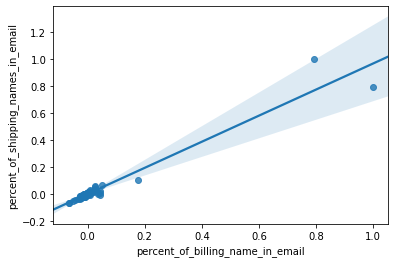

In [15]:
sns.regplot(x="percent_of_billing_name_in_email", y="percent_of_shipping_names_in_email", data=corr_matrix)

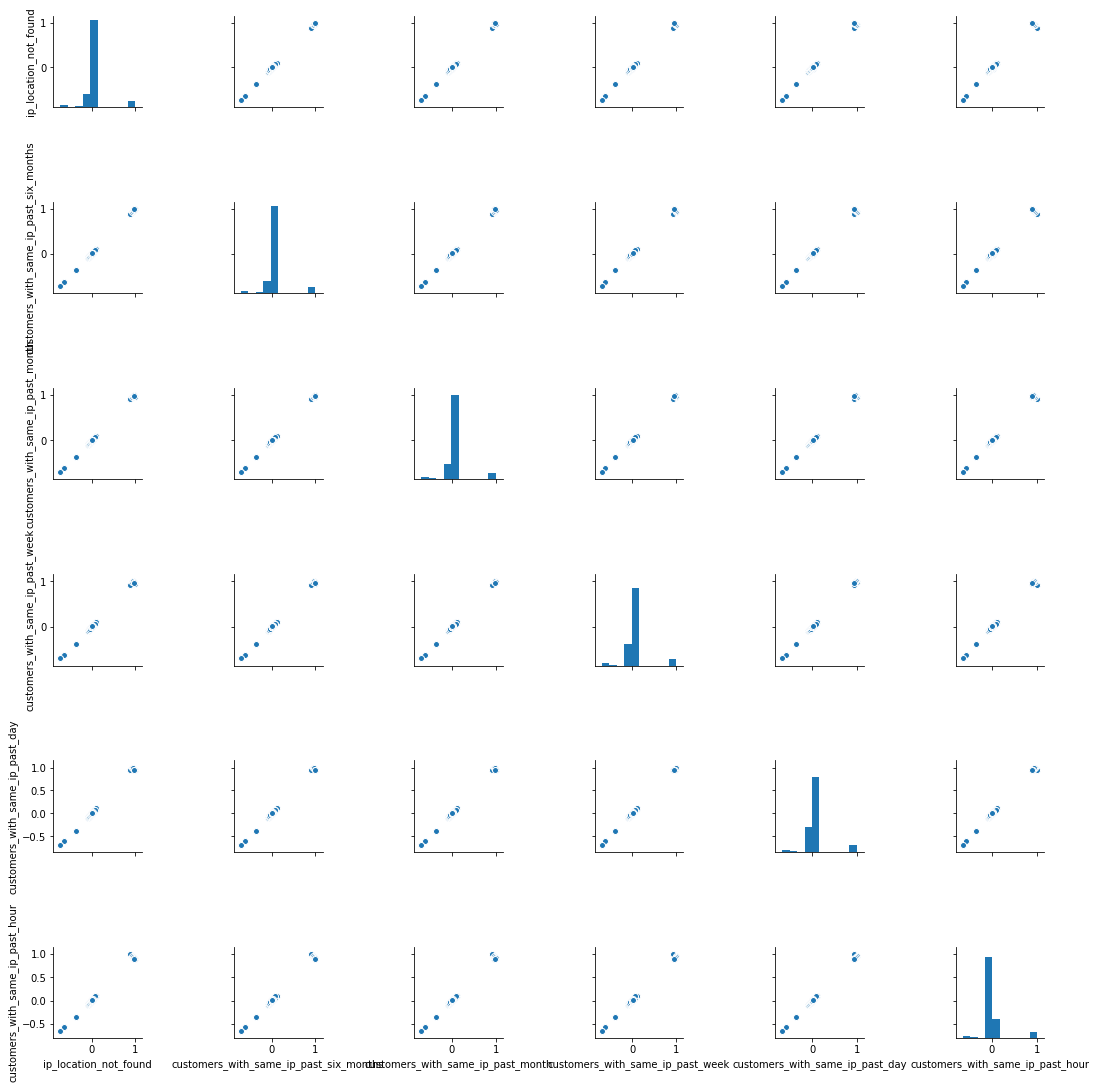

In [338]:
sns.pairplot(corr_matrix[['ip_location_not_found', 'customers_with_same_ip_past_six_months', 'customers_with_same_ip_past_month','customers_with_same_ip_past_week', 'customers_with_same_ip_past_day', 'customers_with_same_ip_past_hour' ]])

## Compute the Fraud Dollars

In [16]:
ot = df.iloc[y_test.index]['order_total']

In [17]:
df2 = pd.concat([ot, y_test], axis=1)
df2 = df2.reset_index(drop=True)
#df2.head()

In [18]:
#p = pd.Series(y_pred)
p = pd.Series(y_fraud_prob)

In [19]:
df3 = pd.concat([df2, p], axis=1)

In [20]:
df3.rename(columns = {'is_fraud':'y_true', 0:'fraud likelihood'}, inplace=True)
#df3.head()

In [21]:
df3.head()

,order_total,y_true,fraud likelihood
0,228.85,0.0,0.034463
1,123.09,0.0,0.425545
2,287.96,0.0,0.242785
3,111.93,0.0,0.447240
4,80.38,0.0,0.084269


In [22]:
df3['dollar scaled likelihood'] = df3['fraud likelihood'] * df3['order_total']

In [23]:
#df3.sort_values('dollar scaled likelihood', ascending=False).head(15)
df3.sort_values(['fraud likelihood', 'order_total'], ascending=False).head(15)

,order_total,y_true,fraud likelihood,dollar scaled likelihood
71,2847.95,1.0,1.0,2847.95
2081,2847.95,1.0,1.0,2847.95
5218,2847.95,1.0,1.0,2847.95
6280,2847.95,1.0,1.0,2847.95
18620,2847.95,1.0,1.0,2847.95
11032,1139.96,0.0,1.0,1139.96
2938,1070.98,1.0,1.0,1070.98
4678,1070.98,1.0,1.0,1070.98
4761,1070.98,1.0,1.0,1070.98
4868,1070.98,1.0,1.0,1070.98


In [24]:
# Find the first 500
df_500 = df3[:500]
df_500.shape

(500, 4)

In [25]:
df3_fraud_dollars = df3.query('y_true==1')
print('Total fraud dollars in the test set:', df3_fraud_dollars['order_total'].sum())

Total fraud dollars in the test set: 722150.8111999999


In [26]:
#df3_fraud_dollars_pred = df3_fraud_dollars.query('fraud likelihood > 0.5')
print('Total fraud dollars in the predicted set:', df_500['order_total'].sum())

Total fraud dollars in the predicted set: 129472.0324


In [27]:
print('Fraud dollar percentage:',  df_500['order_total'].sum() / df3_fraud_dollars['order_total'].sum())

Fraud dollar percentage: 0.17928669523316879


## Fix overfitting

In [28]:
x = StandardScaler().fit_transform(X)

pca = PCA(n_components=60)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)

In [29]:
principalDf.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,1.272382,0.519340,0.068457,-2.738353,0.917642,0.619840,0.114834,-4.537337,-1.151121,0.181173,...,0.766693,0.214574,-1.364711,-1.257942,1.337424,0.375474,0.115140,-0.236642,-0.240237,-1.255482
1,0.021713,-0.498985,-0.550906,-1.011460,0.998148,1.113342,-0.577947,-1.915158,-0.693523,0.037412,...,0.878620,-1.072501,-0.485919,0.294557,0.878049,0.032836,0.204309,0.187467,-0.129196,0.035018
2,-0.169777,-0.678950,-0.991924,1.192751,0.351735,0.369348,-0.516997,-1.055702,-0.798044,-0.923247,...,0.114667,-1.285689,0.595285,1.202133,0.569549,0.346057,0.197456,-0.293010,0.182100,0.155075
3,-0.243002,0.184461,-0.568722,-0.103476,-1.315067,1.111044,-0.507428,-1.607024,-0.193168,0.072521,...,-0.481231,0.360991,-1.266876,0.375901,-0.243324,0.333722,-0.496503,-2.293371,-1.697572,4.737938
4,-0.183352,0.347678,0.050620,0.114145,1.280783,-0.035360,0.589257,-2.088211,-2.278141,-1.533858,...,-0.095374,0.095402,0.467899,0.548661,-0.472891,-0.047936,-0.965672,0.210206,0.238961,0.296078


In [30]:
pca.explained_variance_ratio_.sum()

0.9262320960026128

In [31]:
model = LogisticRegression(class_weight='balanced')
#model = RandomForestClassifier(n_estimators=100)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


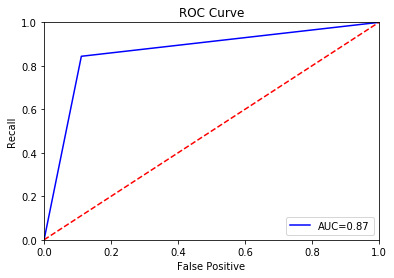

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94     19000
         1.0       0.29      0.84      0.43      1000

    accuracy                           0.89     20000
   macro avg       0.64      0.87      0.68     20000
weighted avg       0.96      0.89      0.91     20000

[[16885  2115]
 [  156   844]]


In [32]:
for train_indices, test_indices in splitter.split(principalDf, y):
    X_train, y_train = principalDf.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test = principalDf.iloc[test_indices], y.iloc[test_indices]
    
#     X_train = StandardScaler().fit_transform(X_train)
#     X_test = StandardScaler().fit_transform(X_test)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    fpr, recall, th = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, recall)
    plt.title('ROC Curve')
    plt.plot(fpr,recall, 'b', label='AUC=%0.2f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.ylabel('Recall')
    plt.xlabel('False Positive')
    plt.show()
    
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

In [33]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=0)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

pipeline = Pipeline([
    ('clf', LogisticRegression())
])
parameters= {'clf__penalty': ('l1','l2'),
            'clf__C': (0.01, 0.1, 1, 10)}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, scoring = 'f1')

grid_search.fit(X_train, y_train)
print ('Best score: %0.3f' % grid_search.best_score_)
print ('Best parameter set:')
best_parameters = grid_search.best_estimator_.get_params()

for p in sorted(parameters.keys()):
    print ('\t%s: %r' % (p, best_parameters[p]))

predictions = grid_search.predict(X_test)
print (classification_report(y_test, predictions))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best score: 0.553
Best parameter set:
	clf__C: 0.1
	clf__penalty: 'l2'
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     47493
         1.0       0.77      0.44      0.56      2507

    accuracy                           0.97     50000
   macro avg       0.87      0.72      0.77     50000
weighted avg       0.96      0.97      0.96     50000

